# Empirical Expected Points Added Model

#### Authors

**Iain Muir**, iam9ez  
**Hriday Singh**, hns4dc  
**Connor Smith**, cms6xs

## Table of Contents

* **0. Import Libraries**
* **1. Load Data**
* **2. Feature Selection and Engineering**
    * 2.1 Remove Garbage Time
    * 2.2 Split Score to Home/Away
    * 2.3 Group Point Periods
* **3. Transform Data for Modeling**
* **4. Field Goal Model**
* **5. Run Models**
* **6. Pass Models**
* **7. Expected Points Added Model**

### 0. Import Libraries

In [1]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
SEED = 42

### 1.0 Load Data

#### 1.1 Aggregate Data across Years

In [4]:
ROOT = '/Users/iainmuir/Desktop/4Y 1S/STAT 4800/Dataset/{} PFF All Plays.csv'

In [5]:
DATA = pd.DataFrame()

In [6]:
%%time

for year in range(2015, 2020):
    PATH = ROOT.format(year)
    df = pd.read_csv(PATH, low_memory=False)
    DATA = pd.concat([DATA, df])

CPU times: user 46.5 s, sys: 16.9 s, total: 1min 3s
Wall time: 1min 28s


In [7]:
DATA.shape

(758971, 177)

In [8]:
DATA.head()

,pff_PLAYID,pff_GAMEID,pff_GAMEDATE,pff_GAMESEASON,pff_WEEK,pff_GSISGAMEKEY,pff_GSISPLAYID,pff_QUARTER,pff_DOWN,pff_CLOCK,...,pff_STSAFETIES,pff_TACKLE,pff_TACKLEASSIST,pff_TEALIGNMENT,pff_TOUCHDOWN,pff_UNBLOCKEDPRESSURE,pff_VISE,pff_WRALIGNMENT,pff_PLAYCLOCK,pff_RUNPASSOPTION
0,1455513,5573,12/31/15,2015,PO,60761,35,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1455434,5573,12/31/15,2015,PO,60761,49,1,1,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
2,1455470,5573,12/31/15,2015,PO,60761,68,1,2,14:33,...,NaN,SCCL D15,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
3,1455450,5573,12/31/15,2015,PO,60761,90,1,3,14:03,...,NaN,SCCL D18,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0
4,1455419,5573,12/31/15,2015,PO,60761,112,1,1,13:51,...,NaN,SCCL D91,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0


In [9]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758971 entries, 0 to 167026
Columns: 177 entries, pff_PLAYID to pff_RUNPASSOPTION
dtypes: float64(30), int64(30), object(117)
memory usage: 1.0+ GB


In [10]:
d = DATA.copy()

### 2.0 Feature Selection and Engineering

#### 2.1 Remove Garbage Time

In [11]:
d = d.loc[d['pff_GARBAGETIME'] == 0]

In [12]:
d = d.reset_index(drop=True)

In [13]:
d.shape

(721010, 177)

#### 2.2 Split Score to Home/Away

In [14]:
def split_score(row):
    """
    
    """
    score = row['pff_SCORE']
    
    if '.' in score:
        h, a = score.split('.')
        if len(a) == 1:
            a = int(a)
            a *= 10
    else:
        h = score
        a = 0
    
    return int(h), int(a)

In [15]:
%%time

d['pff_SCORE'] = d['pff_SCORE'].astype(str)
s = pd.DataFrame(d['pff_SCORE'])
scores = s.apply(
    lambda r: split_score(r),
    axis=1,
    result_type='expand'
)

CPU times: user 3min 3s, sys: 3.04 s, total: 3min 6s
Wall time: 3min 52s


In [16]:
scores.columns = ['homeScore', 'awayScore']

In [17]:
d['homeScore'], d['awayScore'] = scores['homeScore'], scores['awayScore']

#### 2.3 Create Point Periods

In [18]:
def group_point_periods(row):
    """
    
    """
    global drive, prev_qtr, last_id, increment
    
    id_, clock, order, type_ = row['pff_GAMEID'], row['pff_CLOCK'], row['pff_SORTORDER'], row['pff_SPECIALTEAMSTYPE']

    if increment:
        drive += 1
        increment = False
        
    if id_ != last_id:
        drive = 1
    last_id = id_
    
    if str(clock) == '15:00:00' and order != 1:
        drive += 1
        return drive

    increment = True if type_ == 'KICKOFF' and order != 1 else False
        
    return drive

In [19]:
drive = 1
prev_qtr = None
last_id = None
increment = False

In [20]:
%%time

games = pd.DataFrame(
    d[['pff_GAMEID', 'pff_CLOCK', 'pff_SORTORDER', 'pff_SPECIALTEAMSTYPE']]
)
d['pointPeriod'] = games.apply(
    lambda r: group_point_periods(r),
    axis=1
)

CPU times: user 58.4 s, sys: 4.93 s, total: 1min 3s
Wall time: 1min 26s


In [21]:
periods = d.groupby(
    ['pff_GAMEID', 'pointPeriod']
)

In [22]:
%%time

point_periods = list()
for name, group in periods:
    g = group.reset_index(drop=True)
    num = len(g)
    
    home = g['homeScore'].iloc[-1] - g['homeScore'].iloc[0]
    away = g['awayScore'].iloc[-1] - g['awayScore'].iloc[0]
    
    diff = home - away
    points = np.ones(num) * diff

    point_periods.extend(points)

CPU times: user 43.9 s, sys: 5.4 s, total: 49.3 s
Wall time: 1min 2s


In [23]:
d['periodScore'] = point_periods

In [24]:
d.shape

(721010, 181)

In [25]:
d = d.loc[d['periodScore'] < 14]

In [26]:
d.shape

(720713, 181)

In [27]:
d.head()

,pff_PLAYID,pff_GAMEID,pff_GAMEDATE,pff_GAMESEASON,pff_WEEK,pff_GSISGAMEKEY,pff_GSISPLAYID,pff_QUARTER,pff_DOWN,pff_CLOCK,...,pff_TOUCHDOWN,pff_UNBLOCKEDPRESSURE,pff_VISE,pff_WRALIGNMENT,pff_PLAYCLOCK,pff_RUNPASSOPTION,homeScore,awayScore,pointPeriod,periodScore
0,1455513,5573,12/31/15,2015,PO,60761,35,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,0.0,0,0,1,-7.0
1,1455434,5573,12/31/15,2015,PO,60761,49,1,1,15:00,...,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0,0,0,1,-7.0
2,1455470,5573,12/31/15,2015,PO,60761,68,1,2,14:33,...,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0,0,0,1,-7.0
3,1455450,5573,12/31/15,2015,PO,60761,90,1,3,14:03,...,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0,0,0,1,3.0
4,1455419,5573,12/31/15,2015,PO,60761,112,1,1,13:51,...,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0,0,0,1,3.0


### 3.0 Transform All Data

#### 3.1 Subset Data Sets

In [28]:
PLAYS = d.loc[(d['pff_RUNPASS'] == 'P') | (d['pff_RUNPASS'] == 'R')]
FGS = d.loc[d['pff_SPECIALTEAMSTYPE'].astype(str) == 'FIELD GOAL']

In [29]:
print("Plays:", PLAYS.shape)
print("FGs:", FGS.shape)

Plays: (578119, 181)
FGs: (12545, 181)


#### 3.2 Column Transformer and Selection

###### 3.2.1 Run + Pass

In [30]:
rp = PLAYS['pff_RUNPASS']

In [98]:
INPUTS = [
    'pff_DOWN', 'pff_DISTANCE', 'pff_FIELDPOSITION', 'pff_GAINLOSSNET', 'pff_PASSRESULT',
    'homeScore', 'awayScore', 'pointPeriod', 'periodScore'
]

In [99]:
model_p = PLAYS[INPUTS]

In [100]:
model_p.isnull().sum()

pff_DOWN                  0
pff_DISTANCE              0
pff_FIELDPOSITION         0
pff_GAINLOSSNET           0
pff_PASSRESULT       274257
homeScore                 0
awayScore                 0
pointPeriod               0
periodScore               0
dtype: int64

In [101]:
model_p['pff_PASSRESULT'] = model_p['pff_PASSRESULT'].fillna('RUN')

In [102]:
model_p.isnull().sum().sum()

0

In [103]:
print("Plays:", model_p.shape)

Plays: (578119, 9)


In [104]:
model_p.head()

,pff_DOWN,pff_DISTANCE,pff_FIELDPOSITION,pff_GAINLOSSNET,pff_PASSRESULT,homeScore,awayScore,pointPeriod,periodScore
1,1,10,-25,-6,SACK,0,0,1,-7.0
2,2,16,-19,9,RUN,0,0,1,-7.0
3,3,7,-28,17,RUN,0,0,1,3.0
4,1,10,-45,1,RUN,0,0,1,3.0
5,1,10,-46,15,INCOMPLETE,0,0,1,3.0


In [105]:
TARGET = 'pff_GAINLOSSNET'
X_p = model_p.drop(TARGET, axis=1)
y_p = model_p[TARGET]

In [37]:
# num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler())
# ])
# X_prep_p = num_pipeline.fit_transform(X_p)
# X_prep_p = pd.DataFrame(X_prep_p, columns=X_p.columns.tolist())
# X_prep_p = X_prep_p.join(rp.reset_index(drop=True))

In [106]:
X_prep_p = X_p.join(rp.reset_index(drop=True))

In [107]:
X_prep_p.head()

,pff_DOWN,pff_DISTANCE,pff_FIELDPOSITION,pff_PASSRESULT,homeScore,awayScore,pointPeriod,periodScore,pff_RUNPASS
1,1,10,-25,SACK,0,0,1,-7.0,R
2,2,16,-19,RUN,0,0,1,-7.0,R
3,3,7,-28,RUN,0,0,1,3.0,R
4,1,10,-45,RUN,0,0,1,3.0,P
5,1,10,-46,INCOMPLETE,0,0,1,3.0,R


In [108]:
print("Plays:", X_prep_p.shape)

Plays: (578119, 9)


In [109]:
print("Plays:", y_p.shape)

Plays: (578119,)


In [110]:
X_prep_p = X_prep_p.join(y_p)

In [111]:
RUN = X_prep_p.loc[X_prep_p['pff_RUNPASS'] == 'R']
PASS = X_prep_p.loc[X_prep_p['pff_RUNPASS'] == 'P']

In [112]:
print("Run:", RUN.shape)
print("Pass:", PASS.shape)

Run: (219982, 10)
Pass: (243673, 10)


###### 3.2.2 Field Goals

In [44]:
FGS[['kickResult', 'kickLocation']] = FGS['pff_KICKRESULT'].str.split(' - ', expand=True)
FGS['kickResult'] = np.where(FGS['kickResult'] == 'MISSED', 0, 1)

In [45]:
INPUTS = [
    'pff_HASH', 'pff_KICKYARDS', 'kickResult'
]

In [46]:
model_fg = FGS[INPUTS]

In [47]:
model_fg.shape

(12545, 3)

In [48]:
model_fg = model_fg.dropna()

In [49]:
model_fg.shape

(12532, 3)

In [50]:
TARGET = 'kickResult'
X_fg = model_fg.drop(TARGET, axis=1)
y_fg = model_fg[TARGET]

In [51]:
hash_, yards = X_fg['pff_HASH'], X_fg['pff_KICKYARDS']
hash_ = np.array(hash_).reshape(-1, 1)
one_hot = OneHotEncoder(sparse=True).fit_transform(hash_).toarray()
hash_ = pd.DataFrame(one_hot, columns=['hash_C', 'hash_L', 'hash_R'])
X_prep_fg = hash_.join(yards.reset_index(drop=True).astype(int))

In [52]:
X_prep_fg.head()

,hash_C,hash_L,hash_R,pff_KICKYARDS
0,0.0,1.0,0.0,26
1,0.0,0.0,1.0,36
2,0.0,0.0,1.0,22
3,0.0,1.0,0.0,43
4,0.0,0.0,1.0,47


### 4.0 Field Goal Model

#### 4.1 Threshold Experimentation

In [53]:
def metrics(model, x, y, threshold=0.5):
    y_prob = model.predict_proba(x)[:, 1]
    predictions = np.where(y_prob > threshold, 1, 0)
    print("\nConfusion Matrix (t={})".format(threshold))
    print(confusion_matrix(y, predictions))
    f1_ = f1_score(y, predictions)
    print("F1:", f1_)

    return f1_

In [54]:
def log_reg(X, y, threshold=0.5):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )

    lr = LogisticRegression(
        random_state=SEED,
        solver='lbfgs'
    )
    lr = lr.fit(X_train, y_train)
    f1_score = metrics(lr, X_test, y_test, threshold)

    return lr, f1_score

In [55]:
thresholds = np.arange(0.5, 1.05, 0.05)
f1_scores = []
for t in thresholds:
    model, f1 = log_reg(X_prep_fg, y_fg, round(t, 2))
    f1_scores.append(f1)


Confusion Matrix (t=0.5)
[[ 150  532]
 [ 113 1712]]
F1: 0.8414843942000492

Confusion Matrix (t=0.55)
[[ 194  489]
 [ 179 1645]]
F1: 0.8312278928751895

Confusion Matrix (t=0.6)
[[ 243  401]
 [ 279 1584]]
F1: 0.8232848232848233

Confusion Matrix (t=0.65)
[[ 343  314]
 [ 404 1446]]
F1: 0.8011080332409972

Confusion Matrix (t=0.7)
[[ 396  261]
 [ 580 1270]]
F1: 0.7512570245489499

Confusion Matrix (t=0.75)
[[ 505  199]
 [ 695 1108]]
F1: 0.7125401929260451

Confusion Matrix (t=0.8)
[[549 129]
 [923 906]]
F1: 0.6326815642458101

Confusion Matrix (t=0.85)
[[ 626   67]
 [1179  635]]
F1: 0.5047694753577106

Confusion Matrix (t=0.9)
[[ 649   15]
 [1563  280]]
F1: 0.2619270346117867

Confusion Matrix (t=0.95)
[[ 672    0]
 [1835    0]]
F1: 0.0

Confusion Matrix (t=1.0)
[[ 697    0]
 [1810    0]]
F1: 0.0


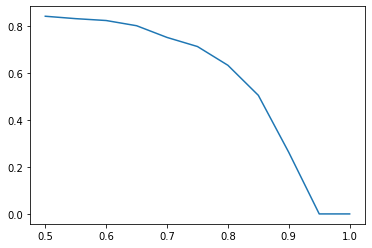

In [56]:
plt.plot(thresholds, f1_scores)
plt.show()

#### 4.2 Final Logistic Regression Model

In [57]:
BEST_THRESHOLD = 0.6

In [58]:
fg_model = log_reg(X_prep_fg, y_fg, 0.6)


Confusion Matrix (t=0.6)
[[ 269  421]
 [ 245 1572]]
F1: 0.8251968503937008


### 5.0 Run Models

In [116]:
RUN = RUN.drop('pff_PASSRESULT', axis=1)

In [118]:
r1 = RUN.loc[RUN['pff_DOWN'] == 1]
r2 = RUN.loc[RUN['pff_DOWN'] == 2]
r3 = RUN.loc[RUN['pff_DOWN'] == 3]
r4 = RUN.loc[RUN['pff_DOWN'] == 4]

In [119]:
print("Running Downs:")
print("\t1st:", r1.shape)
print("\t2nd:", r2.shape)
print("\t3rd:", r3.shape)
print("\t4th:", r4.shape)

Running Downs:
	1st: (97040, 9)
	2nd: (72009, 9)
	3rd: (45589, 9)
	4th: (4791, 9)


#### Calculate Median and Standard Deviation

In [136]:
r1['group'] = pd.qcut(r1['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])
r2['group'] = pd.qcut(r2['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])
r3['group'] = pd.qcut(r3['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])
r4['group'] = pd.qcut(r4['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])

In [137]:
r1_s, r1_m, r1_l = r1.loc[r1['group'] == 'short'], r1.loc[r1['group'] == 'medium'], r1.loc[r1['group'] == 'long']
r2_s, r2_m, r2_l = r2.loc[r2['group'] == 'short'], r2.loc[r2['group'] == 'medium'], r2.loc[r2['group'] == 'long']
r3_s, r3_m, r3_l = r3.loc[r3['group'] == 'short'], r3.loc[r3['group'] == 'medium'], r3.loc[r3['group'] == 'long']
r4_s, r4_m, r4_l = r4.loc[r4['group'] == 'short'], r4.loc[r4['group'] == 'medium'], r4.loc[r4['group'] == 'long']

In [138]:
print("Running Categories:")
print("\t1st:", r1.shape)
print("\t\t1st Short:", r1_s.shape)
print("\t\t1st Medium:", r1_m.shape)
print("\t\t1st Long:", r1_l.shape)
print("\t2nd:", r2.shape)
print("\t\t2nd Short:", r2_s.shape)
print("\t\t2nd Medium:", r2_m.shape)
print("\t\t2nd Long:", r2_l.shape)
print("\t3rd:", r3.shape)
print("\t\t3rd Short:", r3_s.shape)
print("\t\t3rd Medium:", r3_m.shape)
print("\t\t3rd Long:", r3_l.shape)
print("\t4th:", r4.shape)
print("\t\t4th Short:", r4_s.shape)
print("\t\t4th Medium:", r4_m.shape)
print("\t\t4th Long:", r4_l.shape)

Running Categories:
	1st: (97040, 10)
		1st Short: (50086, 10)
		1st Medium: (23994, 10)
		1st Long: (22960, 10)
	2nd: (72009, 10)
		2nd Short: (37237, 10)
		2nd Medium: (17560, 10)
		2nd Long: (17212, 10)
	3rd: (45589, 10)
		3rd Short: (22929, 10)
		3rd Medium: (12156, 10)
		3rd Long: (10504, 10)
	4th: (4791, 10)
		4th Short: (2747, 10)
		4th Medium: (918, 10)
		4th Long: (1126, 10)


#### Mixture Models

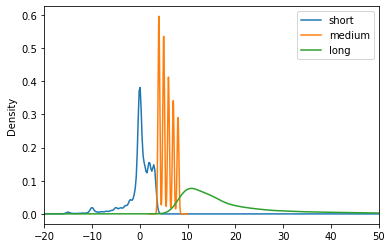

In [158]:
r1_s['pff_GAINLOSSNET'].plot.density()
r1_m['pff_GAINLOSSNET'].plot.density()
r1_l['pff_GAINLOSSNET'].plot.density()
plt.xlim(-20, 50)
plt.legend(labels=['short', 'medium', 'long'])
plt.show()

In [200]:
from sklearn.mixture import GaussianMixture

def plot_mixture(gm):
    """
    
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = np.linspace(-25, 50, 1000).reshape(1000, 1)
    logprob = gm.score_samples(x)
    pdf = np.exp(logprob)
    
    ax.plot(x, pdf, '-k')
    plt.show()
    

def mixture_model(x, plot=True):
    """
    
    """
    x = np.array(x['pff_GAINLOSSNET'])
    
    gm = GaussianMixture(
        n_components=3, random_state=SEED
    ).fit(x.reshape(-1, 1))
    
    if plot:
        plot_mixture(gm)
    
    return gm

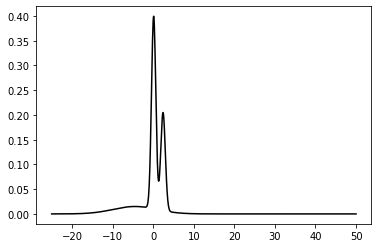

In [201]:
m = mixture_model(r1_s)

In [203]:
gm_r1_s, gm_r1_m, gm_r1_l, gm_r2_s, gm_r2_m, gm_r2_l, gm_r3_s, gm_r3_m, gm_r3_l, gm_r4_s, gm_r4_m, gm_r4_l = range(0, 12)
models = [
    gm_r1_s, gm_r1_m, gm_r1_l,
    gm_r2_s, gm_r2_m, gm_r2_l,
    gm_r3_s, gm_r3_m, gm_r3_l,
    gm_r4_s, gm_r4_m, gm_r4_l
]
vals = [
    r1_s, r1_m, r1_l,
    r2_s, r2_m, r2_l,
    r3_s, r3_m, r3_l,
    r4_s, r4_m, r4_l
]
labels = [
    'short_1', 'medium_1', 'long_1',
    'short_2', 'medium_2', 'long_2',
    'short_3', 'medium_3', 'long_3',
    'short_4', 'medium_4', 'long_4',
]
mixture_dict = {}

for m, v, l in zip(models, vals, labels):
    m = mixture_model(v, plot=False)
    mixture_dict[l] = m

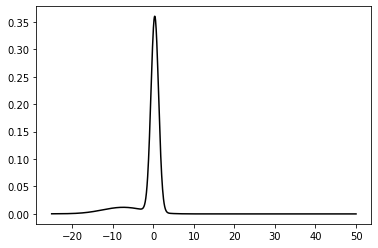

In [207]:
plot_mixture(mixture_dict['short_4'])

### 6.0 Pass Models

In [121]:
p1 = PASS.loc[PASS['pff_DOWN'] == 1]
p2 = PASS.loc[PASS['pff_DOWN'] == 2]
p3 = PASS.loc[PASS['pff_DOWN'] == 3]
p4 = PASS.loc[PASS['pff_DOWN'] == 4]

In [122]:
print("Passing Downs:")
print("\t1st:", p1.shape)
print("\t2nd:", p2.shape)
print("\t3rd:", p3.shape)
print("\t4th:", p4.shape)

Passing Downs:
	1st: (107268, 10)
	2nd: (79709, 10)
	3rd: (50658, 10)
	4th: (5458, 10)


#### Calculate Median and Standard Deviation

In [139]:
p1['group'] = pd.qcut(p1['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])
p2['group'] = pd.qcut(p2['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])
p3['group'] = pd.qcut(p3['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])
p4['group'] = pd.qcut(p4['pff_GAINLOSSNET'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])

In [140]:
p1_s, p1_m, p1_l = p1.loc[p1['group'] == 'short'], p1.loc[p1['group'] == 'medium'], p1.loc[p1['group'] == 'long']
p2_s, p2_m, p2_l = p2.loc[p2['group'] == 'short'], p2.loc[p2['group'] == 'medium'], p2.loc[p2['group'] == 'long']
p3_s, p3_m, p3_l = p3.loc[p3['group'] == 'short'], p3.loc[p3['group'] == 'medium'], p3.loc[p3['group'] == 'long']
p4_s, p4_m, p4_l = p4.loc[p4['group'] == 'short'], p4.loc[p4['group'] == 'medium'], p4.loc[p4['group'] == 'long']

In [141]:
print("Passing Categories:")
print("\t1st:", p1.shape)
print("\t\t1st Short:", p1_s.shape)
print("\t\t1st Medium:", p1_m.shape)
print("\t\t1st Long:", p1_l.shape)
print("\t2nd:", p2.shape)
print("\t\t2nd Short:", p2_s.shape)
print("\t\t2nd Medium:", p2_m.shape)
print("\t\t2nd Long:", p2_l.shape)
print("\t3rd:", p3.shape)
print("\t\t3rd Short:", p3_s.shape)
print("\t\t3rd Medium:", p3_m.shape)
print("\t\t3rd Long:", p3_l.shape)
print("\t4th:", p4.shape)
print("\t\t4th Short:", p4_s.shape)
print("\t\t4th Medium:", p4_m.shape)
print("\t\t4th Long:", p4_l.shape)

Passing Categories:
	1st: (107268, 11)
		1st Short: (55608, 11)
		1st Medium: (26289, 11)
		1st Long: (25371, 11)
	2nd: (79709, 11)
		2nd Short: (41194, 11)
		2nd Medium: (19577, 11)
		2nd Long: (18938, 11)
	3rd: (50658, 11)
		3rd Short: (25485, 11)
		3rd Medium: (13611, 11)
		3rd Long: (11562, 11)
	4th: (5458, 11)
		4th Short: (3135, 11)
		4th Medium: (968, 11)
		4th Long: (1355, 11)


#### Mixture Models

#### Reference

Ref: 
* [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)  
* [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
* [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

### 7.0 Expected Points Added Model

In [233]:
points = list()
MAX = max(d['pff_DISTANCE'])
SEED = 42

YTG_DEV = {
    'long': 4,
    'medium': 3,
    'short': 2,
    'inches': 1
}
YTG_MIN = {
    'long': 10,
    'medium': 6,
    'short': 3,
    'inches': 1
}
POSITION_DEV = 5 # yards

In [238]:
def EPA(down, ytg, position, own):
    """
    
    """
    global points
    
    ytg_dev = 4 if ytg in range(10, MAX) else \
              3 if ytg in range(6, 10) else \
              2 if ytg in range(3, 6) else \
              1
                
    SIMULATIONS = 1000
    for i in range(SIMULATIONS):
        point = run_play(down, ytg, position, own)
        points.append(point)
    
    return np.array(points).mean()

In [239]:
def run_play(down, ytg, position, own):
    dist_ = 'long' if ytg in range(10, MAX) else \
            'medium' if ytg in range(6, 10) else \
            'short' if ytg in range(3, 6) else \
            'inches'
    ytg_dev = YTG_DEV[dist_]
    ytg_min = YTG_MIN[dist_]
    
    position *= -1 if own else 1
    fp_right = position - POSITION_DEV
    fp_left = position + POSITION_DEV
    
    # Off the field left
    if fp_left > 0 and fp_right < 0:
        fp_left = -1
    # Redzone -- shrink deviation to 3 yards
    elif 0 < position < 20:
        fp_right += 2
        fp_left -= 2
    
    samples = d.loc[
        (d['pff_DOWN'] == down) &
        (d['pff_DISTANCE'] >= max(ytg_min, ytg - ytg_dev)) &
        (d['pff_DISTANCE'] <= ytg + ytg_dev) &
        (d['pff_FIELDPOSITION'] >= fp_right) &
        (d['pff_FIELDPOSITION'] <= fp_left)
    ]
    if len(samples) == 0:
        return None
    else:
        sample = samples.sample(n=1, random_state=SEED)
        
        # Define conditions for a TD, FG
        if True:
            score = True
            scored = 6
            
            xps = d.loc[
                (d['pff_DOWN'] == 0) &
                (d['pff_DISTANCE'] == 0) &
                (d['pff_FIELDPOSITION'] == 0)
            ]
            xp = xps.sample(n=1, random_state=SEED)
            result = xp['pff_KICKRESULT']
            scored += 1 if 'MADE' in result else 0
        elif True:
            score = True
            scored = 3
        else:
            score = False
    
    if score:
        return scored
    else:
        return run_play(d, y, p)

In [ ]:
down = int(input('Down: ').strip())
ytg = int(input('Yards to Go: ').strip())
position = int(input('Field Position: ').strip())
own = input('Possession (home/away): ').strip()
own = True if own == 'home' else False

In [ ]:
STATE = {
    'down': down,
    'ytg': ytg,
    'position': position,
    'own': own
}

In [ ]:
epa = EPA(**STATE)

In [ ]:
print('''
    Expected Points Model:
    S (Down: {}, YTG: {}, Position: {}) == {} EP
'''.format(
    STATE['down'],
    STATE['ytg'],
    ('Own ' if STATE['own'] else '') + str(STATE['position']),
    epa
))